# Tacotron Synthesis Notebook


# Select Tacotron model

Copy and paste the link to your model, but remove the "https://drive.google.com/file/d/" and "/view?usp=sharing", so it's just the code part. If you don't have a model, I've included some models that you can use (I'll add more in the future)

In [20]:

tacotron2_pretrained_model = '/home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outdir/checkpoint_11000'
waveglow_pretrained_model = '/home/Ciro/Desktop/sansone-english-finetuning/tacotron2/waveglow/waveglow.pt'

In [21]:
#@title Initialize Tacotron and Waveglow 
%matplotlib inline
import IPython.display as ipd
import numpy as np
import torch
import matplotlib.pylab as plt
import sys
sys.path.append('waveglow/')

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from text import text_to_sequence
from denoiser import Denoiser

graph_width = 900
graph_height = 360
def plot_data(data, figsize=(int(graph_width/100), int(graph_height/100))):
    %matplotlib inline
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none', cmap='inferno')
    fig.canvas.draw()
    plt.show()

!gdown --id '1IUxCkgRNsoDCLtMZxYXmIePAKgh0m-aZ'
thisdict = {}
for line in reversed((open('merged.dict.txt', "r").read()).splitlines()):
    thisdict[(line.split(" ",1))[0]] = (line.split(" ",1))[1].strip()
def ARPA(text):
    out = ''
    for word_ in text.split(" "):
        word=word_; end_chars = ''
        while any(elem in word for elem in r"!?,.;") and len(word) > 1:
            if word[-1] == '!': end_chars = '!' + end_chars; word = word[:-1]
            if word[-1] == '?': end_chars = '?' + end_chars; word = word[:-1]
            if word[-1] == ',': end_chars = ',' + end_chars; word = word[:-1]
            if word[-1] == '.': end_chars = '.' + end_chars; word = word[:-1]
            if word[-1] == ';': end_chars = ';' + end_chars; word = word[:-1]
            else: break
        try: word_arpa = thisdict[word.upper()]
        except: word_arpa = ''
        if len(word_arpa)!=0: word = "{" + str(word_arpa) + "}"
        out = (out + " " + word + end_chars).strip()
    if out[-1] != ";": out = out + ";"
    return out

#torch.set_grad_enabled(False)

# initialize Tacotron2 with the pretrained model
hparams = create_hparams()

Downloading...
From: https://drive.google.com/uc?id=1IUxCkgRNsoDCLtMZxYXmIePAKgh0m-aZ
To: /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/merged.dict.txt
100%|███████████████████████████████████████| 7.94M/7.94M [00:00<00:00, 159MB/s]


In [23]:
# Load Tacotron2 (run this cell every time you change the model)
#.chdir('..')
hparams.sampling_rate = 22050 # Don't change this
hparams.max_decoder_steps = 1000 # How long the audio will be before it cuts off (1000 is about 11 seconds)
hparams.gate_threshold = 0.1# Model must be 90% sure the clip is over before ending generation (the higher this number is, the more likely that the AI will keep generating until it reaches the Max Decoder Steps)
model = Tacotron2(hparams)
model.load_state_dict(torch.load(tacotron2_pretrained_model)['state_dict'])
_ = model.cuda().eval()

In [30]:
os.chdir('..')

In [24]:
# Load WaveGlowà
#.chdir('waveglow')
waveglow = torch.load(waveglow_pretrained_model)['model']
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow.cuda().eval()
from apex import amp
waveglow, _ = amp.initialize(waveglow, [], opt_level="O3")
denoiser = Denoiser(waveglow)

/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source

Selected optimization level O3:  Pure FP16 training.
Defaults for this optimization level are:
enabled                : True
opt_level              : O3
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : False
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O3
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : False
master_weights         : False
loss_scale             : 1.0


#The actual synthesis part

This is where you actually synthesize the audio! You can input whatever you want. I put in the lyrics to All Star.

Hello everyone, i am professor Sansone.
Hello everyone, i am professor Sansone.;


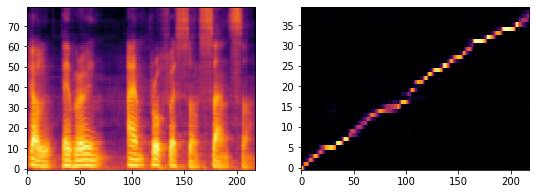

In [30]:
text = "Hello everyone, i am professor Sansone."
sigma = 0.7
denoise_strength = 0.1
raw_input = True # disables automatic ARPAbet conversion, useful for inputting your own ARPAbet pronounciations or just for testing
MAX_WAV_VALUE = 32768.0
for i in text.split("\n"):
    if len(i) < 1: continue;
    print(i)
    if raw_input:
        if i[-1] != ";": i=i+";" 
    else: i = ARPA(i)
    print(i)
    with torch.no_grad(): # save VRAM by not including gradients
        sequence = np.array(text_to_sequence(i, ['english_cleaners']))[None, :]
        sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
        mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
        plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],
                alignments.float().data.cpu().numpy()[0].T))
        audio = waveglow.infer(mel_outputs_postnet.half(), sigma=sigma); print(""); ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate))
       # audio_denoised = denoiser(audio, strength=denoise_strength)[:, 0]
       # audio_denoised = audio_denoised * MAX_WAV_VALUE
        #audio_denoised = audio_denoised.squeeze()
        #audio_numpy = audio_denoised.cpu().numpy().astype('int16')

        from scipy.io.wavfile import write
        write("ciruzzhello.wav", hparams.sampling_rate, audio[0].data.cpu().numpy().astype("int16"))